In [ ]:
## 캐글 데이터 다운
## https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

### 라이브러리

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy.stats import skew

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


%matplotlib inline

In [2]:
house_df = pd.read_csv('./kaggle_data/house_price/house_price.csv')
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
house_df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [5]:
isnull_series = house_df.isnull().sum()
isnull_series

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [6]:
isnull_series[isnull_series > 0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

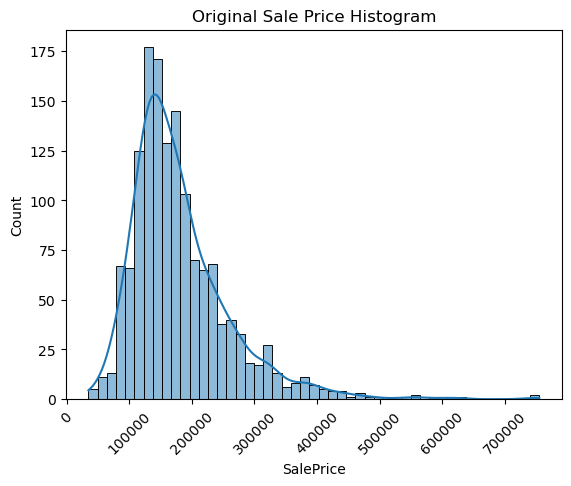

In [7]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation = 45)
sns.histplot(house_df['SalePrice'], kde = True)
plt.show()


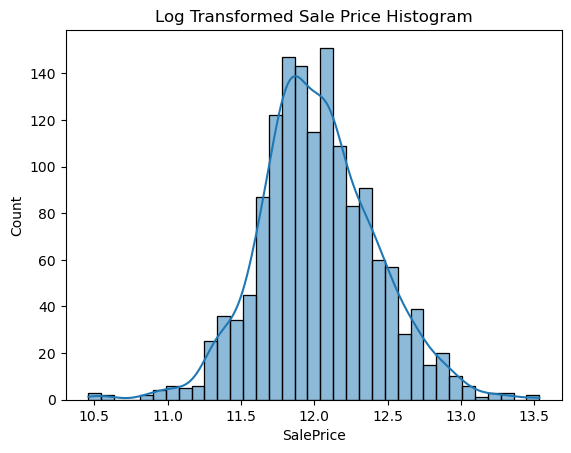

In [8]:
plt.title('Log Transformed Sale Price Histogram')
log_salesPrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_salesPrice, kde = True)
plt.show()

In [9]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# NULL이 너무 많은 컬럼과 불필요한 컬럼
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
                , axis = 1
                , inplace = True)


house_df.fillna(house_df.mean()
                , inplace = True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
house_df.dtypes[null_column_count.index]

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14212\1796404690.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  house_df.fillna(house_df.mean()


MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

In [10]:
house_df_ohe = pd.get_dummies(house_df)

house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]

Series([], dtype: int64)

In [11]:
house_df_ohe.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0


In [12]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice'
                               , axis = 1
                               )

X_train, X_test, y_train, y_test = \
                                train_test_split(X_features
                                                , y_target
                                                , test_size= 0.2
                                                , random_state=156)

In [13]:
# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]

def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    return print(
        f'''
    ▶ 로그 변환된 RMSE
    모델 : {model.__class__.__name__}
    RMSE : {np.round(rmse, 5)}
    R_Squared : {r2_score(y_test, pred):.4f}
          '''
    )
          

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)

    return rmses

get_rmses(models)


    ▶ 로그 변환된 RMSE
    모델 : LinearRegression
    RMSE : 0.1319
    R_Squared : 0.8953
          

    ▶ 로그 변환된 RMSE
    모델 : Ridge
    RMSE : 0.12751
    R_Squared : 0.9021
          

    ▶ 로그 변환된 RMSE
    모델 : Lasso
    RMSE : 0.17628
    R_Squared : 0.8129
          


[None, None, None]

In [14]:
def get_top_bottom_coef(model, n = 10):
    # coef_ 속성을 기반으로 Series 객체를 생성, index는 컬럼명
    coef = pd.Series(model.coef_
                     , index = X_features.columns
                     )
    
    # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14212\898951956.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_concat.values
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14212\898951956.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_concat.values
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14212\898951956.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_concat.values


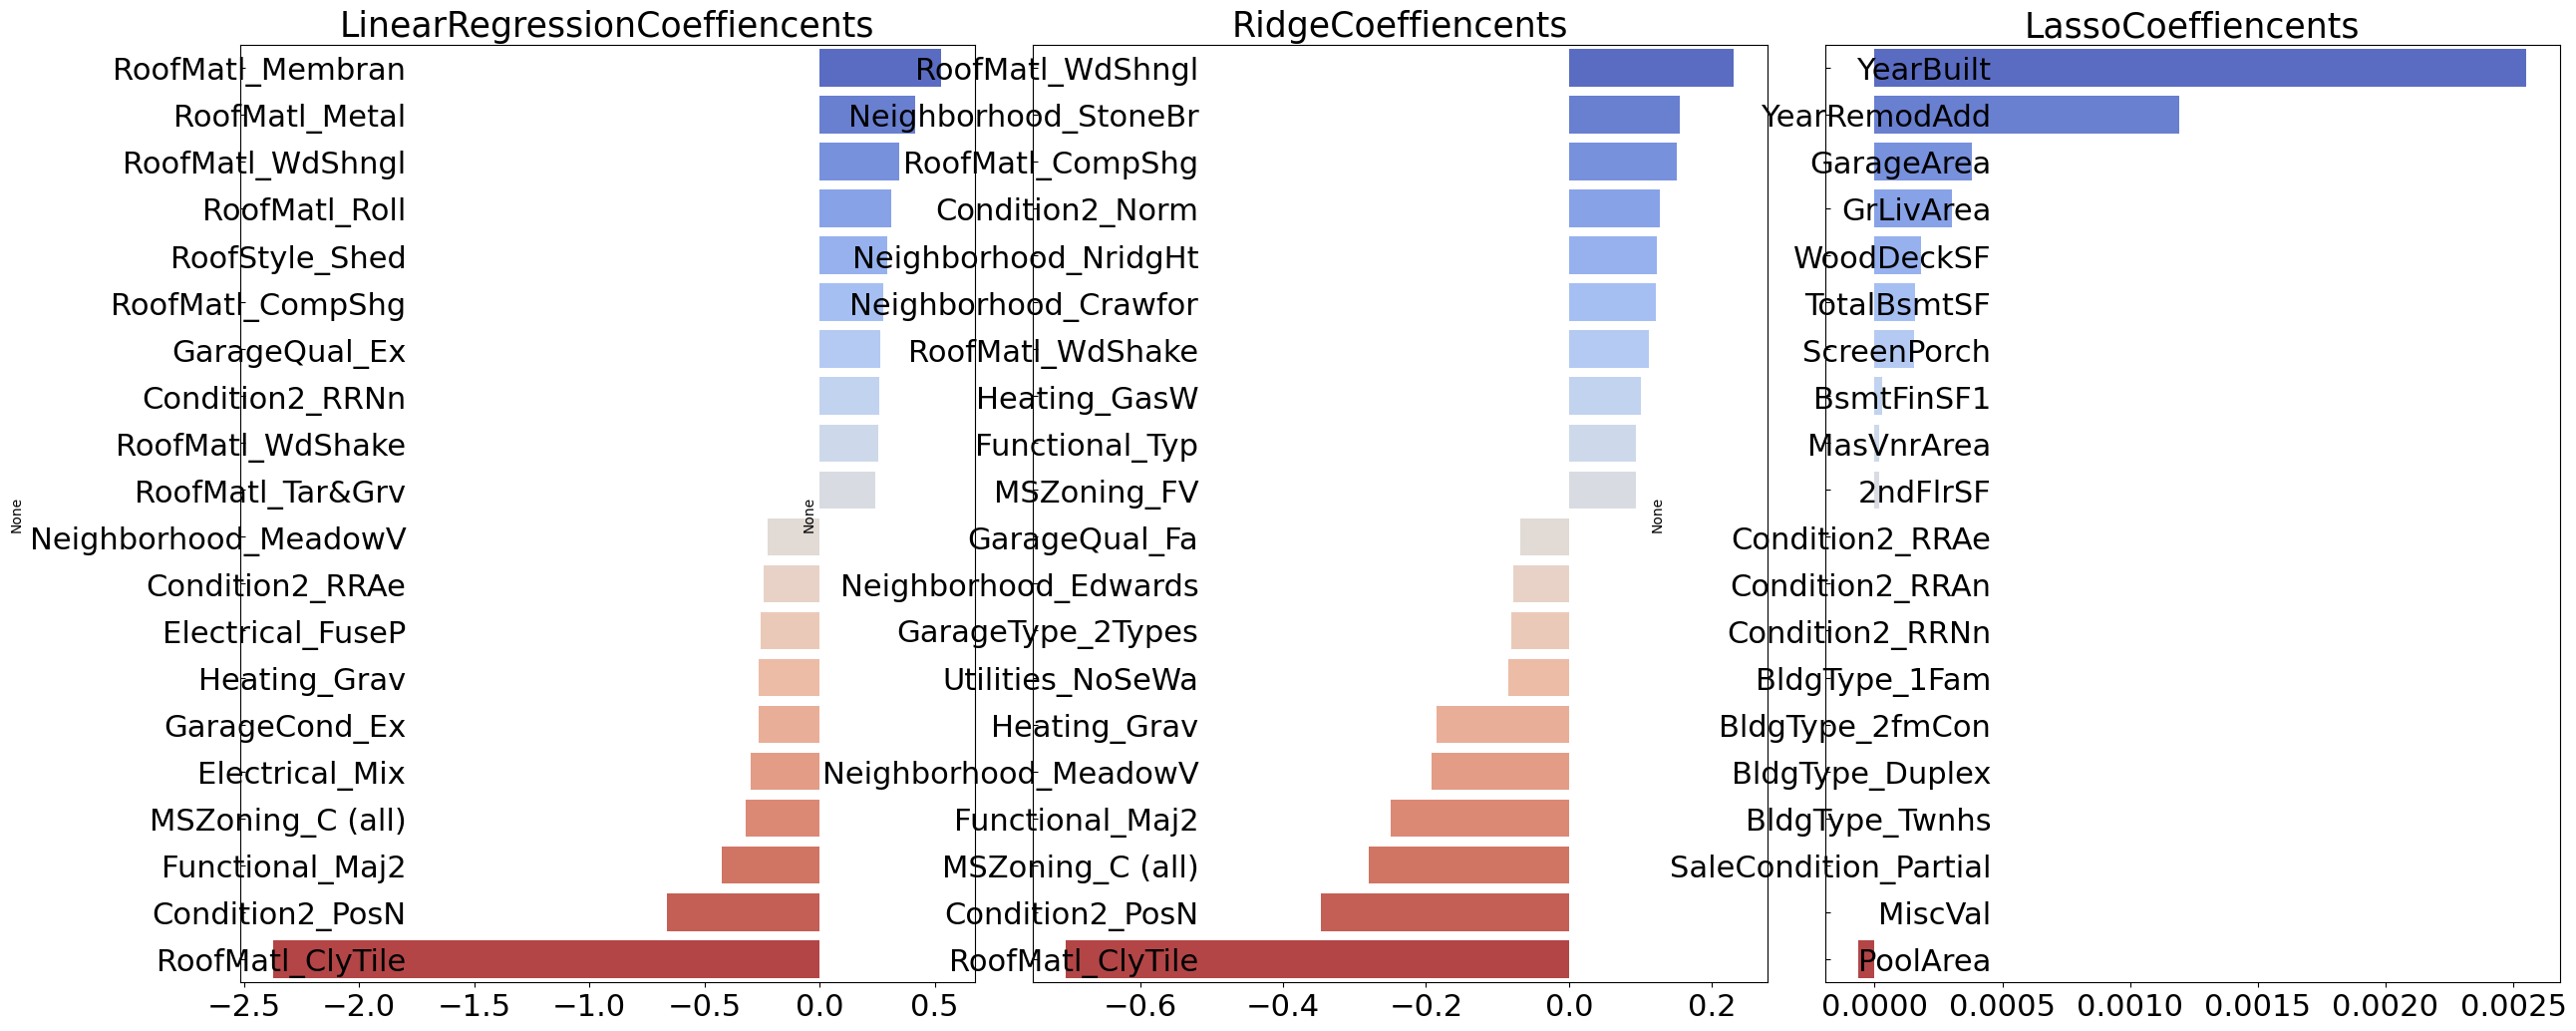

In [15]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해, 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize = (24,10)
                            , nrows = 1
                            , ncols = 3
                            )
    
    fig.tight_layout()

    # 색상
    palette = sns.color_palette("coolwarm", 20)

    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])

        # axs subplot에 barchar로 표현, 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
        axs[i_num].set_title(model.__class__.__name__ + 'Coeffiencents', size = 25)
        axs[i_num].tick_params(axis = 'y', direction = 'in', pad = -120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)

        sns.barplot(x=coef_concat.values
                    , y = coef_concat.index
                    , ax = axs[i_num]
                    , palette=palette[:len(coef_concat)]
                    )
        
    plt.show()

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [16]:
def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring = 'neg_mean_squared_error', cv = 5))

        rmse_avg = np.mean(rmse_list)
    print(f'''
    {model.__class__.__name__, np.round(rmse_list, 5)}
    {model.__class__.__name__, np.round(rmse_avg, 5)}
          ''')
    
models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


    ('Lasso', array([0.16077, 0.20437, 0.17677, 0.18128, 0.26512]))
    ('Lasso', 0.19766)
          


In [33]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model
                              , param_grid = params
                              , scoring = 'neg_mean_squared_error'
                              , cv = 5
                            )
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print(f'''
    ▶ {model.__class__.__name__}일 때

    ▶ 최적 평균 RMSE 값
    {np.round(rmse, 4)}

    ▶ 최적 alpha값
    {grid_model.best_params_}
    ''')

    return grid_model.best_estimator_
    
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)


    ▶ Ridge일 때

    ▶ 최적 평균 RMSE 값
    0.1125

    ▶ 최적 alpha값
    {'alpha': 8}
    

    ▶ Lasso일 때

    ▶ 최적 평균 RMSE 값
    0.1122

    ▶ 최적 alpha값
    {'alpha': 0.001}
    


Lasso(alpha=0.001)


    ▶ 로그 변환된 RMSE
    모델 : LinearRegression
    RMSE : 0.1319
    R_Squared : 0.8953
          

    ▶ 로그 변환된 RMSE
    모델 : Ridge
    RMSE : 0.12387
    R_Squared : 0.9076
          

    ▶ 로그 변환된 RMSE
    모델 : Lasso
    RMSE : 0.11996
    R_Squared : 0.9134
          


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14212\898951956.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_concat.values
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14212\898951956.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_concat.values
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14212\898951956.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_concat.values


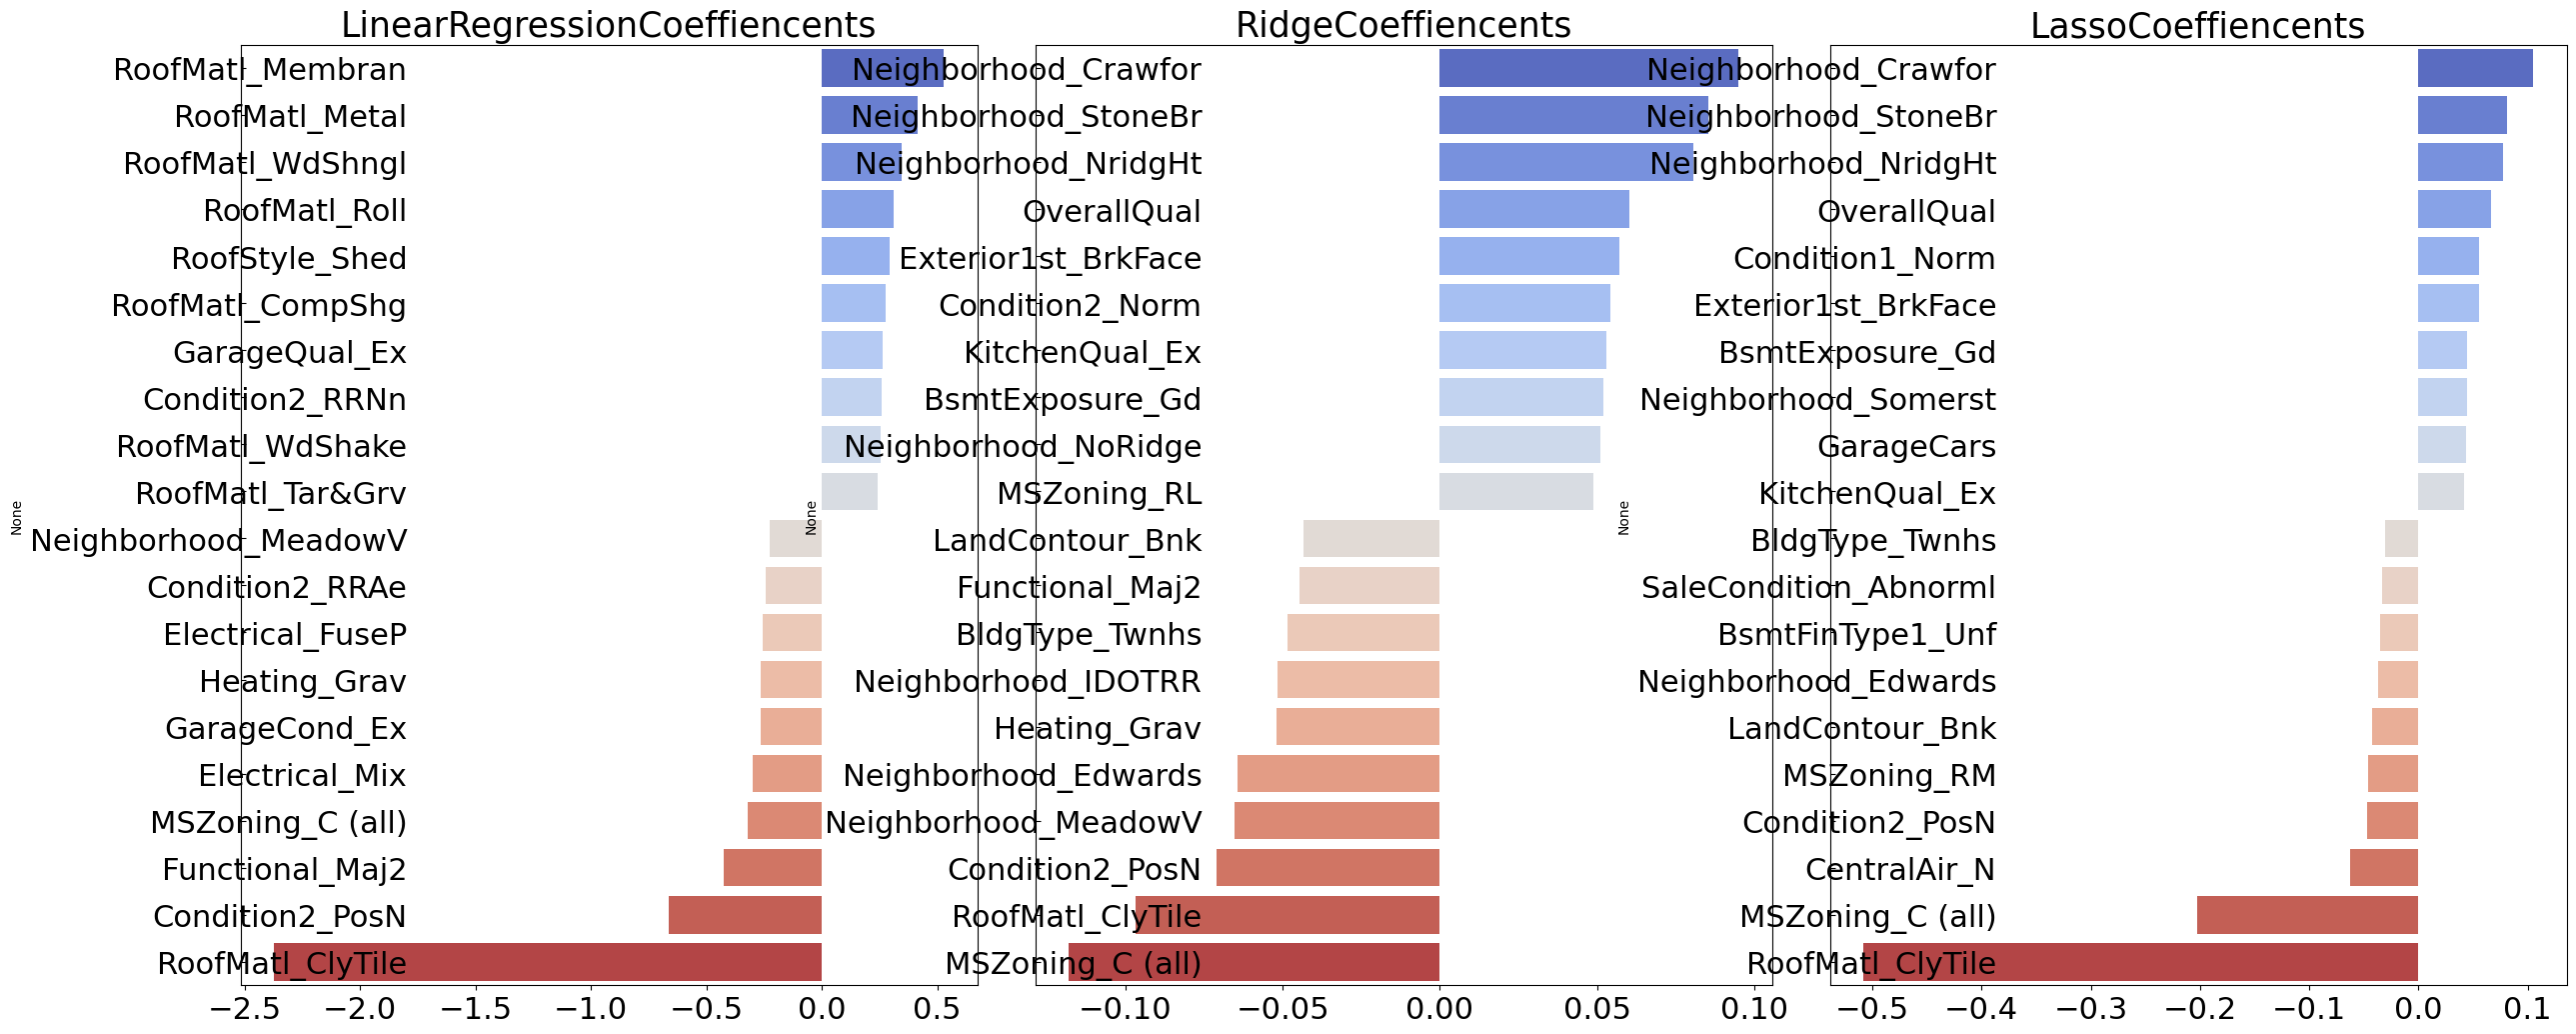

In [18]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha = 12)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

In [19]:
# object가 아닌 숫자형 feature의 컬럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 컬럼 index를 []로 입력하면, 해당 컬럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))

# skew(왜곡) 정도가 1 이상인 컬럼만 추출
skew_featurues_top = skew_features[skew_features > 1]
print(skew_featurues_top.sort_values(ascending = False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [20]:
house_df[skew_featurues_top.index] = np.log1p(house_df[skew_featurues_top.index])
house_df[skew_featurues_top.index]

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,LowQualFinSF,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4.110874,4.189655,9.042040,5.283204,6.561031,0.000000,6.753438,6.753438,0.0,7.444833,0.000000,0.693147,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.000000
1,3.044522,4.394449,9.169623,0.000000,6.886532,0.000000,7.141245,7.141245,0.0,7.141245,0.693147,0.693147,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,4.110874,4.234107,9.328212,5.093750,6.188264,0.000000,6.825460,6.825460,0.0,7.488294,0.000000,0.693147,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.000000
3,4.262680,4.110874,9.164401,0.000000,5.379897,0.000000,6.629363,6.869014,0.0,7.448916,0.000000,0.693147,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.000000
4,4.110874,4.442651,9.565284,5.860786,6.486161,0.000000,7.044033,7.044033,0.0,7.695758,0.000000,0.693147,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.110874,4.143135,8.976894,0.000000,0.000000,0.000000,6.860664,6.860664,0.0,7.407318,0.000000,0.693147,0.000000,3.713572,0.000000,0.0,0.0,0.0,0.000000
1456,3.044522,4.454347,9.486152,4.787492,6.673298,5.099866,7.341484,7.637234,0.0,7.637234,0.000000,0.693147,5.857933,0.000000,0.000000,0.0,0.0,0.0,0.000000
1457,4.262680,4.204693,9.109746,0.000000,5.620401,0.000000,7.050123,7.080868,0.0,7.758333,0.000000,0.693147,0.000000,4.110874,0.000000,0.0,0.0,0.0,7.824446
1458,3.044522,4.234107,9.181735,0.000000,3.912023,6.937314,6.983790,6.983790,0.0,6.983790,0.000000,0.693147,5.905362,0.000000,4.727388,0.0,0.0,0.0,0.000000


In [21]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로, 다시 OHE를 적용하여, 피처 / 타깃 데이터 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis = 1)

X_train, X_test, y_train, y_test = \
                                train_test_split(X_features
                                                , y_target
                                                , test_size = 0.2
                                                , random_state = 156
                                                )

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)


    ▶ Ridge일 때

    ▶ 최적 평균 RMSE 값
    0.1275

    ▶ 최적 alpha값
    {'alpha': 10}
    

    ▶ Lasso일 때

    ▶ 최적 평균 RMSE 값
    0.1252

    ▶ 최적 alpha값
    {'alpha': 0.001}
    



    ▶ 로그 변환된 RMSE
    모델 : LinearRegression
    RMSE : 0.12826
    R_Squared : 0.9010
          

    ▶ 로그 변환된 RMSE
    모델 : Ridge
    RMSE : 0.1225
    R_Squared : 0.9097
          

    ▶ 로그 변환된 RMSE
    모델 : Lasso
    RMSE : 0.11926
    R_Squared : 0.9144
          


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14212\898951956.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_concat.values
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14212\898951956.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_concat.values
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_14212\898951956.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_concat.values


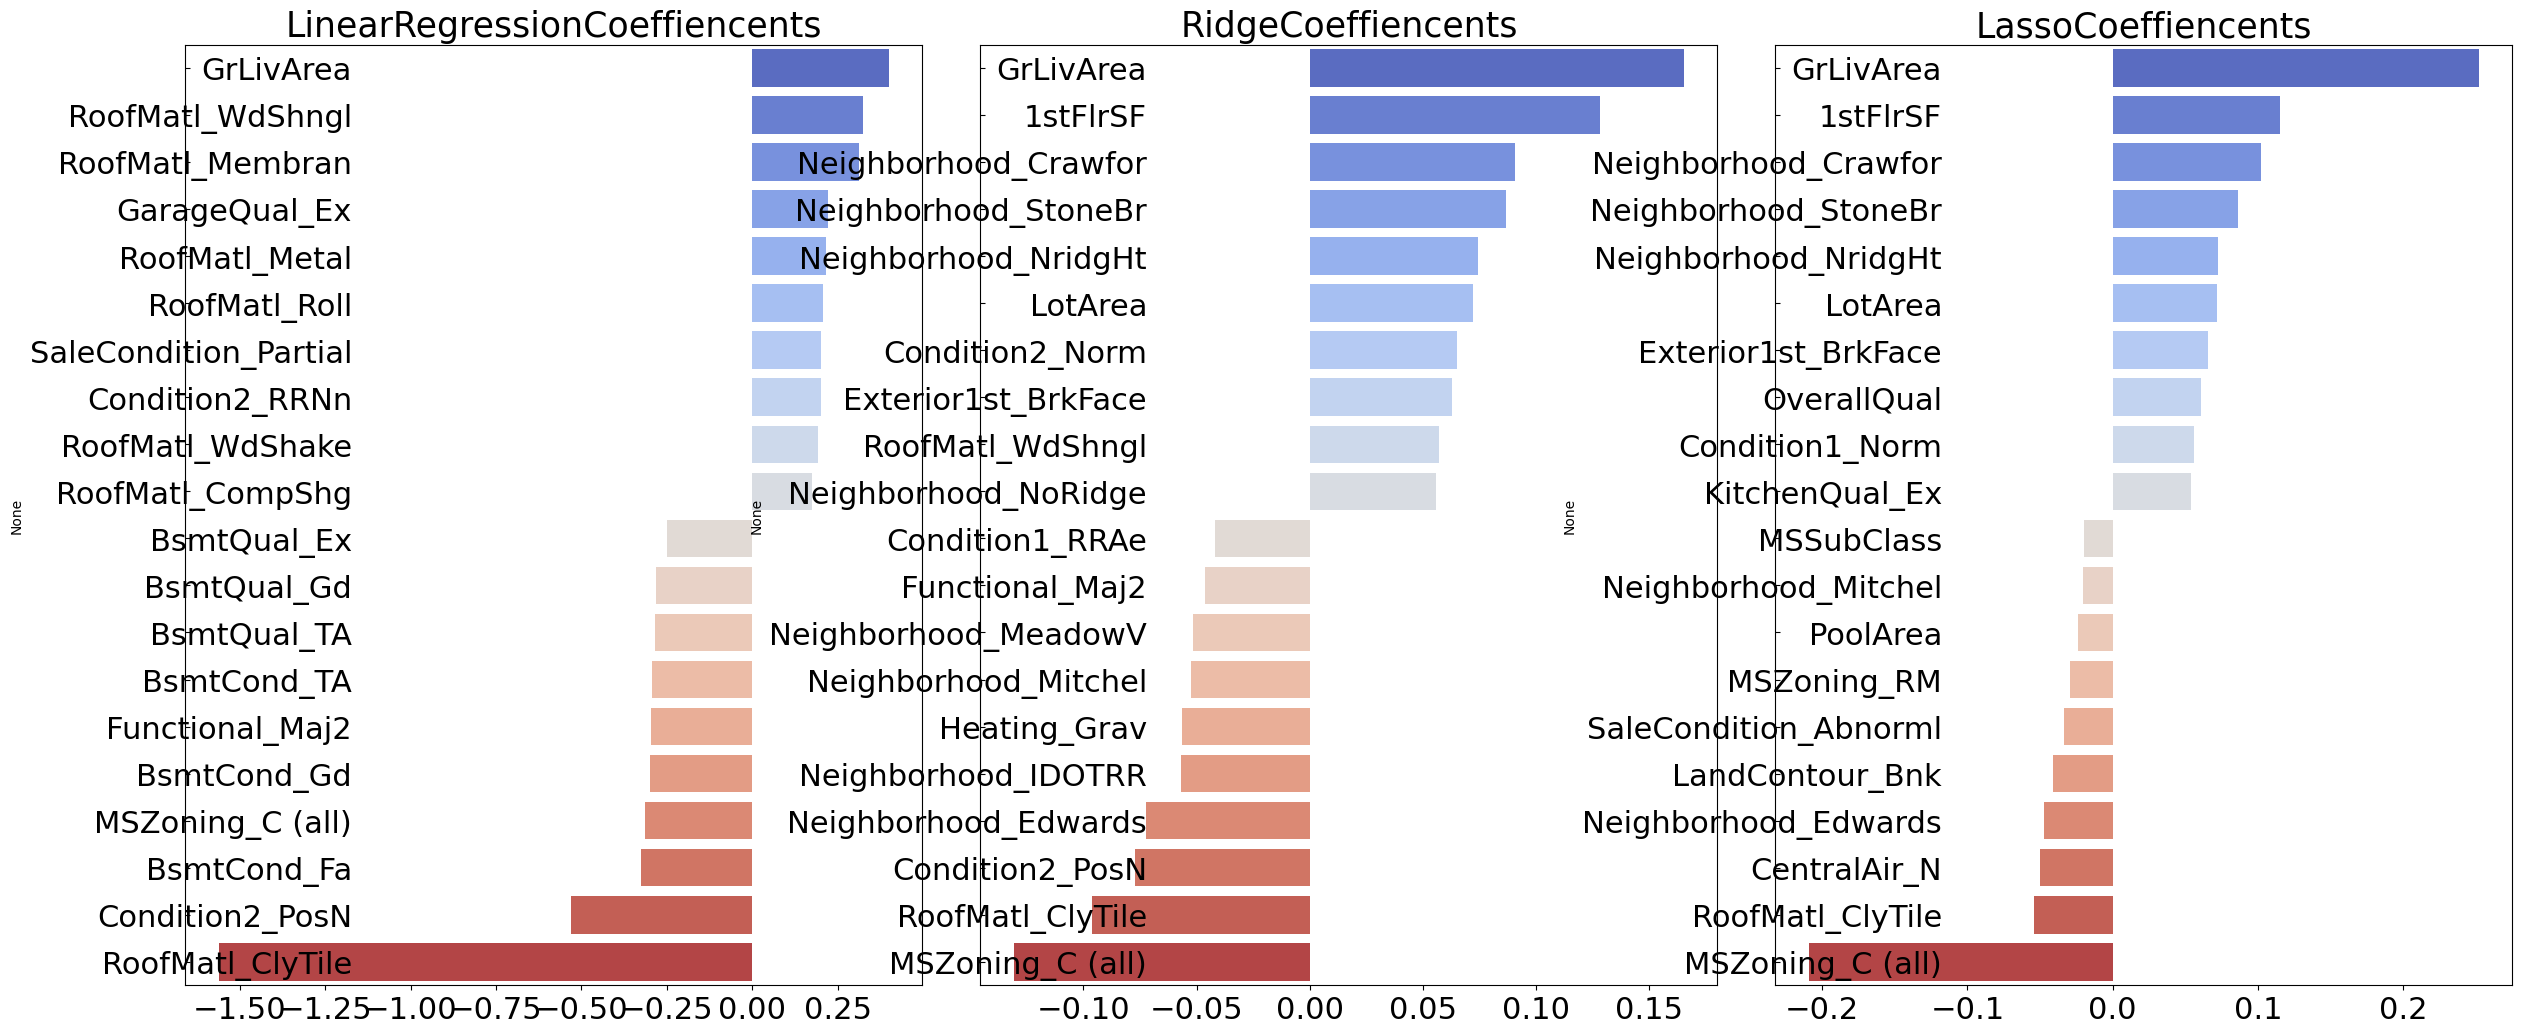

In [22]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

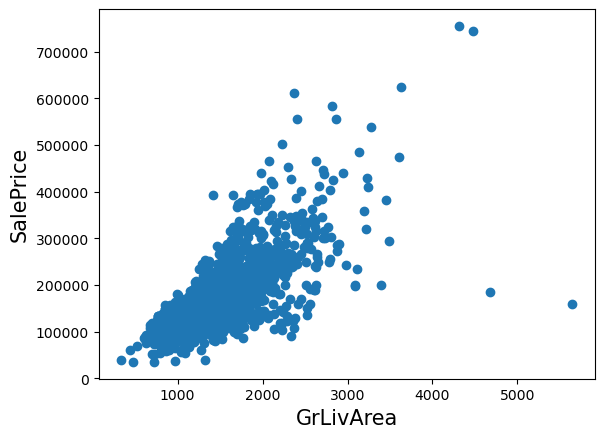

In [23]:
house_df_org = pd.read_csv('./kaggle_data/house_price/house_price.csv')

plt.scatter(x = house_df_org['GrLivArea']
            , y = house_df_org['SalePrice']
            )
plt.ylabel('SalePrice', fontsize = 15)
plt.xlabel('GrLivArea', fontsize = 15)
plt.show()

In [24]:
# 이상치 조건 설정
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)

In [25]:
# 이상치 찾기
outlier_index = house_df_ohe[cond1 & cond2].index
outlier_index

Int64Index([523, 1298], dtype='int64')

In [26]:
# 이상치 제거
house_df_ohe.drop(outlier_index, axis = 0, inplace = True)

In [27]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis = 1, inplace =  False)

X_train, X_test, y_train, y_test = \
                                train_test_split(X_features
                                                , y_target
                                                , test_size=0.2
                                                , random_state=156)

ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)


    ▶ Ridge일 때

    ▶ 최적 평균 RMSE 값
    0.1125

    ▶ 최적 alpha값
    {'alpha': 8}
    

    ▶ Lasso일 때

    ▶ 최적 평균 RMSE 값
    0.1122

    ▶ 최적 alpha값
    {'alpha': 0.001}
    


In [35]:
xgb_params = {'n_estimators' : [1000]}
xgb_reg = XGBRegressor(n_estimators = 1000
                       , learning_rate = 0.05
                       , colsample_bytree = 0.5
                       , subsample = 0.8
                       )

best_xgb = print_best_params(xgb_reg, xgb_params)

lgb_params = {'n_estimators' : [1000]}

lgbm_reg = LGBMRegressor(n_estimators = 1000
                        , learning_rate=0.05
                        , num_leaves = 4
                        , subsample = 0.6
                        , colsample_bytree = 0.4
                        , reg_lambda = 10
                        , n_jobs= -1)

best_lgbm = print_best_params(lgbm_reg, lgb_params)


    ▶ XGBRegressor일 때

    ▶ 최적 평균 RMSE 값
    0.1178

    ▶ 최적 alpha값
    {'n_estimators': 1000}
    

    ▶ LGBMRegressor일 때

    ▶ 최적 평균 RMSE 값
    0.1163

    ▶ 최적 alpha값
    {'n_estimators': 1000}
    


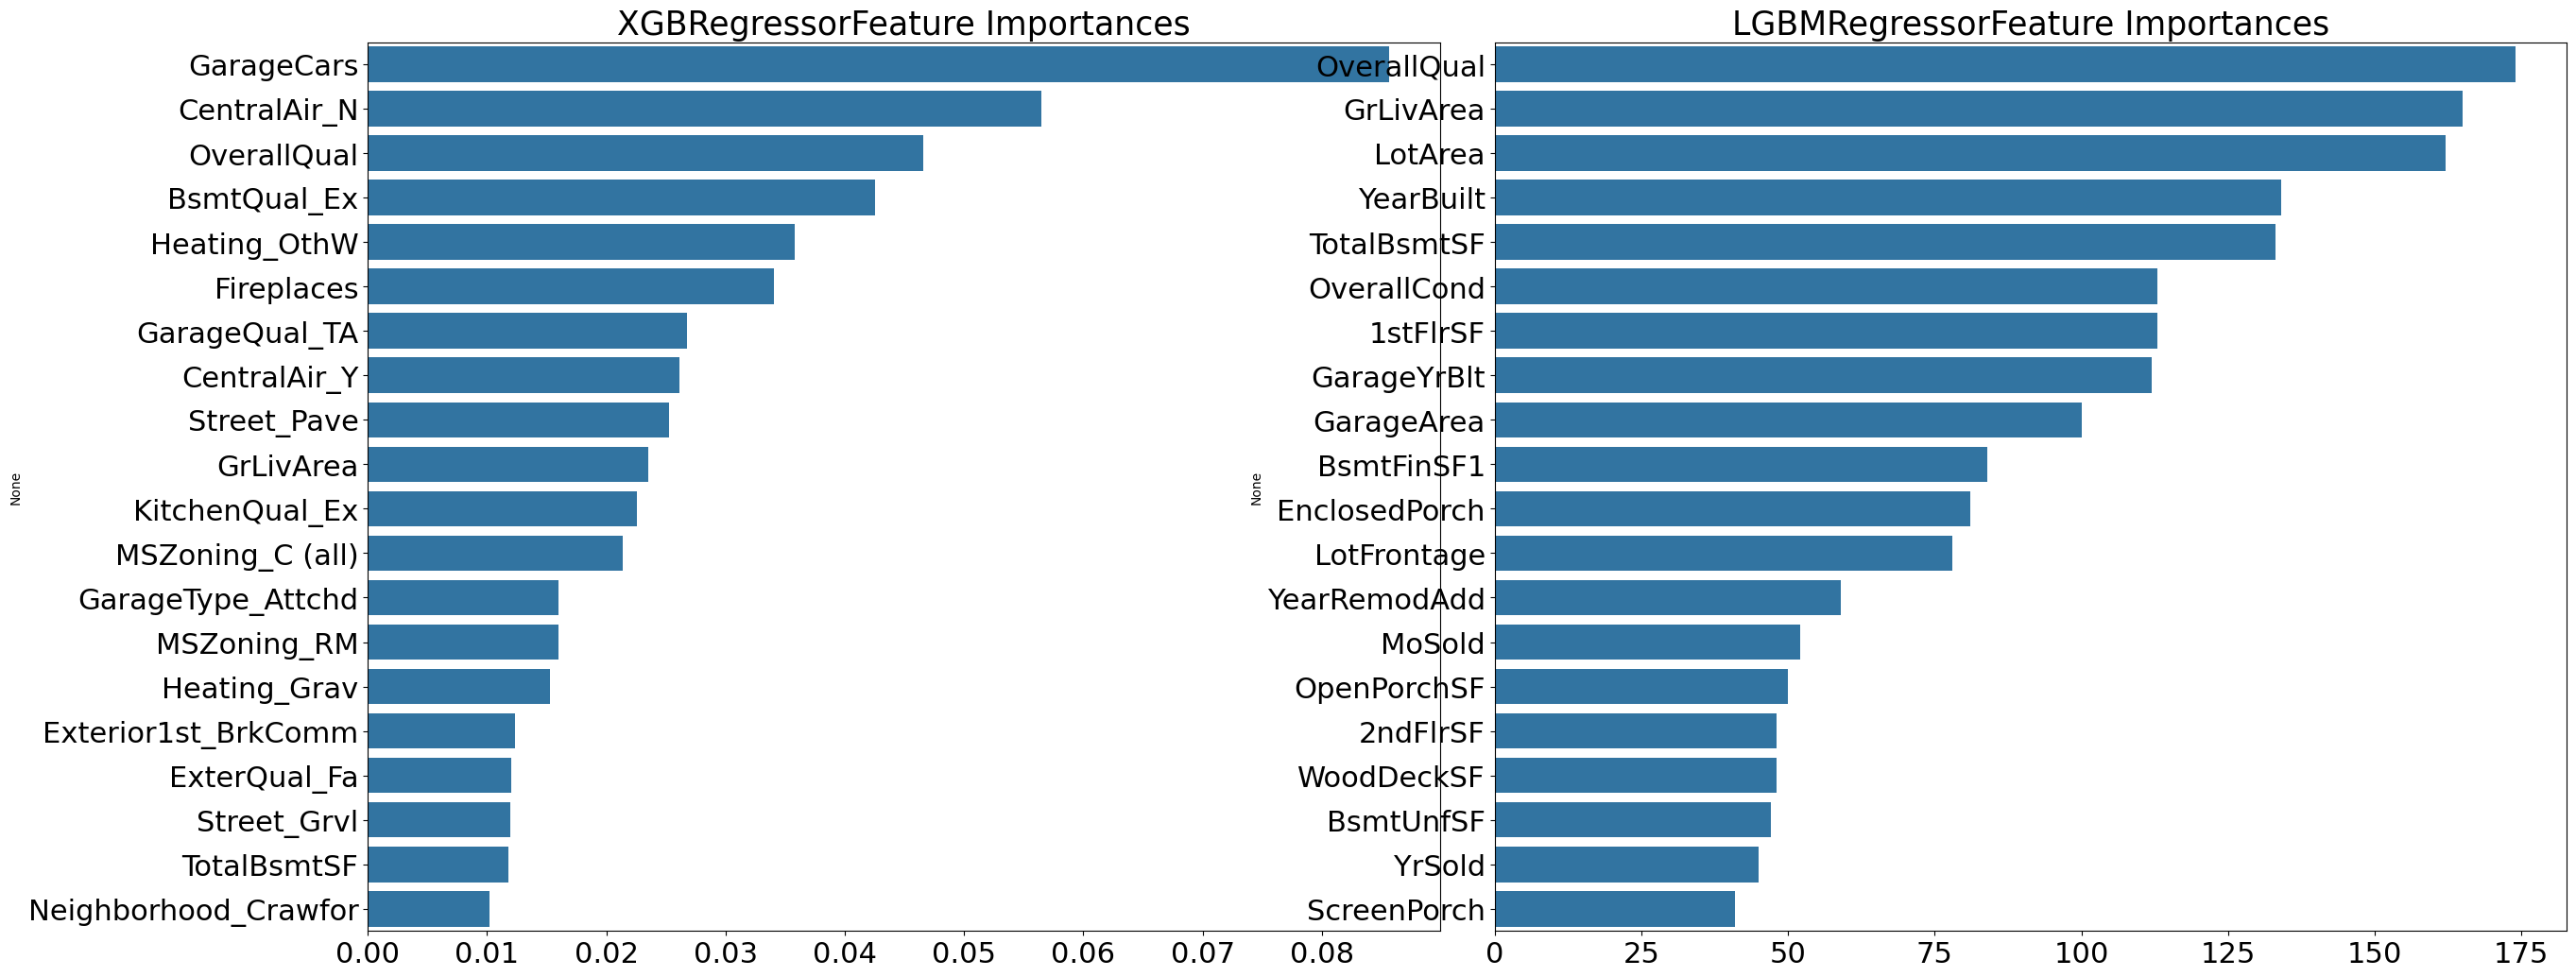

In [37]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index = X_features.columns)
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize = (24, 10), nrows = 1, ncols =2)
    fig.tight_layout()

    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화
    for i_num, model in enumerate(models):
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__ + 'Feature Importances', size = 25)

        # font 크기 조정
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x = ftr_top20.values
                    , y = ftr_top20.index
                    , ax = axs[i_num]
                    )
        
# 앞 예제에서 print_best_params()가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화
models = [best_xgb, best_lgbm]

visualize_ftr_importances(models)

### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

In [38]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print(f'{key, rmse}')

In [39]:
# 개별 모델의 학습
ridge_reg = Ridge(alpha = 8)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델의 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {
        '최종 혼합' : pred
         , 'Ridge' : ridge_pred
         , 'Lasso' : lasso_pred
         }

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)


('최종 혼합', 0.10007930884470514)
('Ridge', 0.10345177546603244)
('Lasso', 0.1002417046089003)


In [42]:
xgb_reg = XGBRegressor(n_estimators = 1000
                       , learning_rate = 0.05
                       , colsample_bytree = 0.5
                       , subsample = 0.8
                       )

lgbm_reg = LGBMRegressor(n_estimators=1000
                         , learning_rate=0.05
                         , num_leaves = 4
                         , subsample = 0.6
                         , colsample_bytree = 0.4
                         , reg_labda = 10
                         , n_jobs = -1
                        )

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred

preds = {
        '최종 혼합' : pred
        , 'XGBM' : xgb_pred
        , 'LGBM' : lgbm_pred
        }

get_rmse_pred(preds)

('최종 혼합', 0.10108182430937865)
('XGBM', 0.10738295638346222)
('LGBM', 0.1020282111912274)


In [49]:
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성
    kf = KFold(n_splits = n_folds, shuffle = False)

    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, '모델 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입려된 학습 데이터에서 기반 모델이 학습 / 예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr,y_tr)

        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)

        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1, 1)

    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [50]:
# get_stacking_base_datasets()는 넘파이, ndarray를 인자로 사용하므로, DataFrame을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(base) 모델이 생성한 학습용 / 테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge 모델 시작
	 폴드 세트 0 시작
	 폴드 세트 1 시작
	 폴드 세트 2 시작
	 폴드 세트 3 시작
	 폴드 세트 4 시작
Lasso 모델 시작
	 폴드 세트 0 시작
	 폴드 세트 1 시작
	 폴드 세트 2 시작
	 폴드 세트 3 시작
	 폴드 세트 4 시작
XGBRegressor 모델 시작
	 폴드 세트 0 시작
	 폴드 세트 1 시작
	 폴드 세트 2 시작
	 폴드 세트 3 시작
	 폴드 세트 4 시작
LGBMRegressor 모델 시작
	 폴드 세트 0 시작
	 폴드 세트 1 시작
	 폴드 세트 2 시작
	 폴드 세트 3 시작
	 폴드 세트 4 시작


In [54]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis = 1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis = 1)

# 최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha = 0.0005)

# 개별 모델 예측값을 기반을 새롭게 만들어진 학습 /테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print(f'스태킹 회귀 모델의 최종값은 RMSE : {rmse:.4f}')

스태킹 회귀 모델의 최종값은 RMSE : 0.0979
